In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import kruskal
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
data = pd.read_csv('/home/wahba/Documents/dataset/processed/3_cicids2017_attack_only.csv')

In [3]:
data.shape

(425831, 61)

In [4]:
# Separate features and target
X = data.drop(columns=['Label', 'Fwd URG Flags', 'RST Flag Count', 'ECE Flag Count'])
y = data['Label']

# Random Forest for feature importance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [5]:
# Kruskal-Wallis test for each feature
kruskal_results = []
for feature in X.columns:
    # Group values by class
    groups = [X[feature][y == label] for label in y.unique()]
    stat, p = kruskal(*groups)
    kruskal_results.append({'Feature': feature, 'H-stat': stat, 'p-value': p})

kruskal_wallis_result_df = pd.DataFrame(kruskal_results).sort_values(by='H-stat', ascending=False)

In [6]:
# Merge on Feature name
combined_df = pd.merge(
    feature_importance_df,
    kruskal_wallis_result_df,
    on='Feature',
    how='inner'
)

# Sort by Random Forest importance (descending)
combined_df = combined_df.sort_values(
    by='Importance',
    ascending=False
)

print(combined_df)


                        Feature    Importance         H-stat        p-value
0             Total Fwd Packets  1.443528e-01  221647.248334   0.000000e+00
1                 Bwd Packets/s  1.324347e-01  219869.097451   0.000000e+00
2                 Fwd IAT Total  7.566737e-02  216829.545305   0.000000e+00
3                  Fwd IAT Mean  7.546547e-02  217299.982843   0.000000e+00
4                 Flow Duration  6.828407e-02  215261.261774   0.000000e+00
5             Fwd Header Length  6.687109e-02  211561.224436   0.000000e+00
6              Destination Port  6.346951e-02  373716.169724   0.000000e+00
7         Bwd Packet Length Min  6.052553e-02  414033.290667   0.000000e+00
8                Flow Packets/s  3.405675e-02  217242.522224   0.000000e+00
9                 Flow IAT Mean  2.871400e-02  217340.293978   0.000000e+00
10                 Flow IAT Max  2.835488e-02  217684.962698   0.000000e+00
11                  Fwd IAT Max  2.622143e-02  218548.680310   0.000000e+00
12          

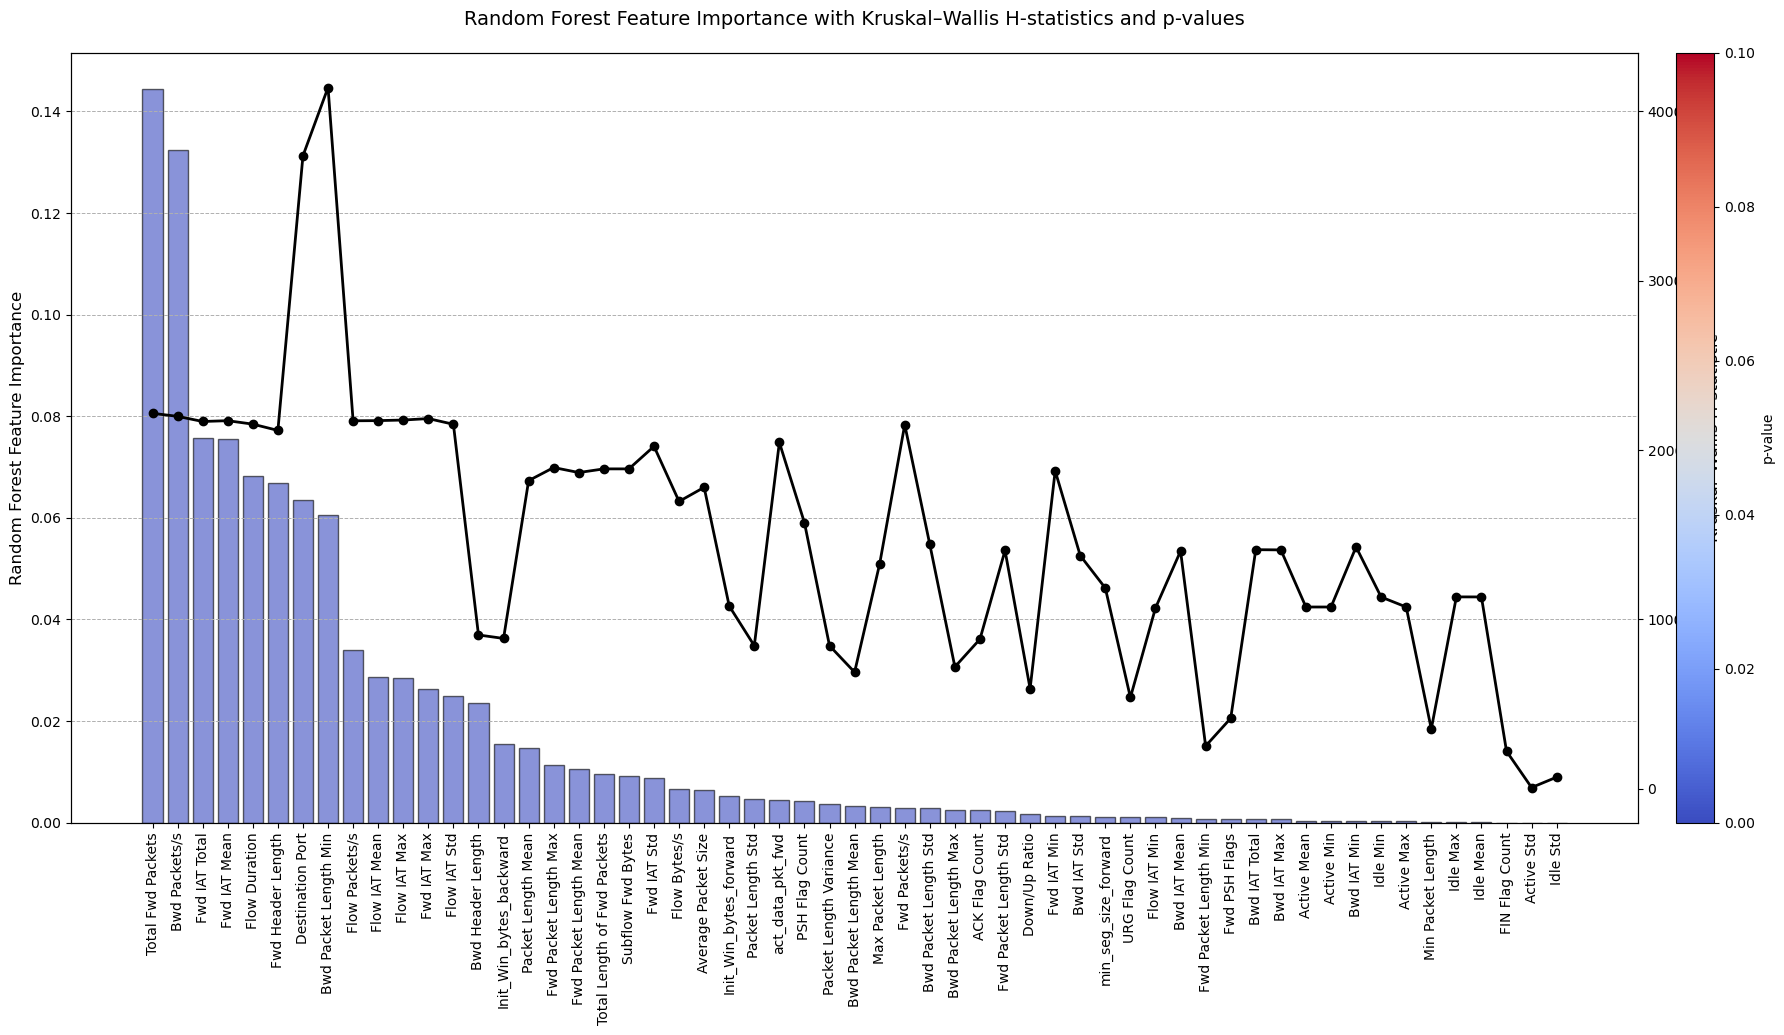

In [7]:
comparison_tb_sorted = combined_df

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(25, 10))
ax2 = ax1.twinx()

# Colormap for p-values
colors = sns.color_palette("coolwarm", as_cmap=True)

# Normalize p-values for coloring
p_min = comparison_tb_sorted['p-value'].min()
p_max = 0.1  # cap for visualization clarity

# Plot Random Forest importance bars
bars = ax1.bar(
    comparison_tb_sorted['Feature'],
    comparison_tb_sorted['Importance'],
    alpha=0.6,
    edgecolor='black',
    color=[
        colors((p - p_min) / (p_max - p_min))
        for p in comparison_tb_sorted['p-value']
    ]
)

# Plot Kruskal–Wallis H-statistic as a line
ax2.plot(
    comparison_tb_sorted['Feature'],
    comparison_tb_sorted['H-stat'],
    color='black',
    linewidth=2,
    marker='o',
    label='Kruskal–Wallis H-stat'
)

# Axis labels
ax1.set_ylabel('Random Forest Feature Importance', fontsize=12)
ax2.set_ylabel('Kruskal–Wallis H-statistic', fontsize=12)

# X-axis formatting
ax1.set_xticks(range(len(comparison_tb_sorted['Feature'])))
ax1.set_xticklabels(
    comparison_tb_sorted['Feature'],
    rotation=90,
    ha='center',
    fontsize=10
)

# Title
plt.title(
    'Random Forest Feature Importance with Kruskal–Wallis H-statistics and p-values',
    fontsize=14,
    pad=20
)

# Make room for colorbar on the right
plt.subplots_adjust(right=0.88)

# Colorbar for p-values
sm = plt.cm.ScalarMappable(
    cmap=colors,
    norm=plt.Normalize(vmin=p_min, vmax=p_max)
)
sm.set_array([])
cbar = plt.colorbar(
    sm,
    ax=ax1,
    orientation='vertical',
    pad=0.02  # reduced from 0.08
)
cbar.set_label('p-value', fontsize=10)

# Gridlines
ax1.grid(True, axis='y', linestyle='--', linewidth=0.7)
ax2.grid(False)

plt.show()